# Import des librairies

In [1]:
import os
import keras
from PIL import Image
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#from keras.utils import img_to_array, load_img
from numpy import argmax
from pathlib import Path
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau

import keras_tuner as kt
from keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2,ResNet101V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2   
from tensorflow.keras.utils import to_categorical
from keras import Model
from keras.layers import Dense
from keras.layers import Flatten


### Vérification de la prise en compte du GPU par tensorflow

In [2]:
# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.9.1


# Importation des images

### Parcours du dossier comprenant les images.

In [3]:
#On définit le nombre de classes 
n_classes = 20

In [4]:
# On initialise l'array images qui prendra ensuite toutes nos images. 
images = []

# On parcours le dossier père : 
for imgDir in os.listdir("/Users/florentmargery/Documents/Open Classroom/Projet 6/Images/10classes/"):
    directory = "/Users/florentmargery/Documents/Open Classroom/Projet 6/Images/10classes/" + imgDir
    # On se place dans le dossier fils
    os.chdir(directory)
    # POur chaque image du dossier fils, on la charge au format souhaité, on la convertie en array et on la normalise
    # avant de l'ajoutere à notre array d'images. 
    for image in os.listdir(directory):
        loadedImg = load_img(image,target_size=(128, 128,3))
        img = img_to_array(loadedImg)
        images.append(img/255.) #/255.

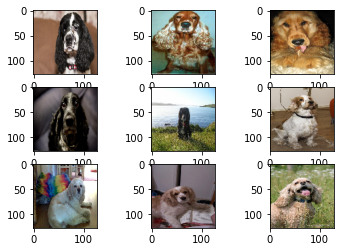

In [5]:
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(images[i], cmap=pyplot.get_cmap('Greys'))
	# show the plot
pyplot.show()

### On récupère les étiquettes des images à travers les fichiers d'annotations

In [6]:
# Fonction permettant de récupérer le nom de l'étiquette dans la balise <name> <name/> 
# renvoie un liste de la taille du nombre d'images au total. 
def get_name(file_name):   
    doc = Path(file_name).read_text().replace('\n', ' ')
    soup = BeautifulSoup(doc)
    annotation = soup.find("name").get_text()
    return annotation

In [11]:
# On itialise l'array annotations qui va récupérer les différentes étiquettes. 
annotations = []
# On parcours l'ensemble des dossiers
for class_name in os.listdir("/Users/florentmargery/Documents/Open Classroom/Projet 6/Annotation/10classes"):
    
    directory = "/Users/florentmargery/Documents/Open Classroom/Projet 6/Annotation/10classes/" + class_name
    os.chdir(directory)
    for file in os.listdir(directory):
    
        os.chdir(directory)
        annotation = get_name(file)
        annotations.append(annotation)

### Encodage des étiquettes : label_encoder, puis OneHotEncoder.

In [12]:
X = images

label_encoder = LabelEncoder()
annotations = label_encoder.fit_transform(annotations)
y=annotations
y = to_categorical(annotations)

#### On enregistre notre encoder

In [13]:
np.save('classes.npy', label_encoder.classes_)

# Preprocessing

In [14]:
X = X
y = y

### Spliting des données pour la validation des modèles.

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, shuffle=True, stratify=y)

y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
len(X_train)

2158

#### Affichage de la répartition des données : chaque classe est bien représentée dans les échantillons de Train et test. (stratify)

In [17]:
label_list = []
for i in range(len(y_test)):
    label = np.argmax(y_test[i])
    label_list.append(label)

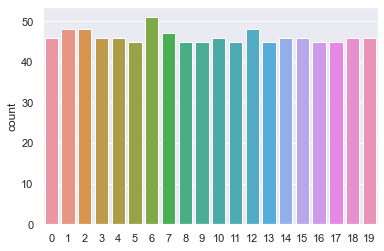

In [18]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=label_list)

### Data Generator pour préprocesser les images ==> Data Augmentation

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        zca_whitening= False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images


datagen.fit(X_train)

In [20]:
#Création d'un ImagedataGenerator vide pour comparer.
no_datagen = ImageDataGenerator()
no_datagen.fit(X_train)

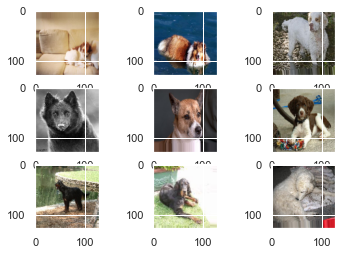

In [21]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(128, 128,3), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

# Création d'un modèle baseline

### Le plus basique 

In [31]:
### building a linear stack of layers with the sequential model
model_bl = models.Sequential()
# hidden layer
model_bl.add(layers.Dense(100, input_shape=(128,128,3), activation='relu'))
model_bl.add(layers.Flatten())
model_bl.add(layers.Dense(n_classes, activation='softmax'))


# Compiler le modèle 
optimizer = SGD(lr=0.01, momentum=0.9)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model_bl.compile(loss="categorical_crossentropy",
                  optimizer=optimizer, metrics=["accuracy"])

# Set a learning rate annealer
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
                                           # factor=0.05, min_lr=0.00001

batch_size = 32
epochs = 50
history_bl = model_bl.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,validation_data=(X_test,y_test),verbose = 2
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


/Users/florentmargery/miniforge3/envs/fastdash_test/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-06-17 16:29:18.075509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 16:30:08.391496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 70s - loss: 3.1712 - accuracy: 0.0700 - val_loss: 2.9114 - val_accuracy: 0.0886 - lr: 0.0100 - 70s/epoch - 1s/step
Epoch 2/50
68/68 - 70s - loss: 2.8091 - accuracy: 0.1307 - val_loss: 2.8458 - val_accuracy: 0.1005 - lr: 0.0100 - 70s/epoch - 1s/step
Epoch 3/50
68/68 - 70s - loss: 2.7664 - accuracy: 0.1450 - val_loss: 2.6980 - val_accuracy: 0.1751 - lr: 0.0100 - 70s/epoch - 1s/step
Epoch 4/50
68/68 - 70s - loss: 2.6655 - accuracy: 0.1696 - val_loss: 2.7685 - val_accuracy: 0.1524 - lr: 0.0100 - 70s/epoch - 1s/step
Epoch 5/50
68/68 - 70s - loss: 2.6163 - accuracy: 0.1923 - val_loss: 2.6149 - val_accuracy: 0.1805 - lr: 0.0100 - 70s/epoch - 1s/step
Epoch 6/50
68/68 - 70s - loss: 2.5987 - accuracy: 0.1821 - val_loss: 2.6612 - val_accuracy: 0.1838 - lr: 0.0100 - 70s/epoch - 1s/step
Epoch 7/50
68/68 - 70s - loss: 2.5971 - accuracy: 0.1840 - val_loss: 2.6234 - val_accuracy: 0.1989 - lr: 0.0100 - 70s/epoch - 1s/step
Epoch 8/50
68/68 - 70s - loss: 2.5674 - accuracy: 0.1784 - val_loss: 2.60

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x28876c3e0>
    label = <none> 
    device = <AGXG13XDevice: 0x138ccac00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x2835f6000>
        label = <none> 
        device = <AGXG13XDevice: 0x138ccac00>
            name = Apple M1 Pro 
    retainedReferences = 1


68/68 - 70s - loss: 2.7819 - accuracy: 0.1228 - val_loss: 2.7844 - val_accuracy: 0.1297 - lr: 1.0000e-03 - 70s/epoch - 1s/step
Epoch 13/50
68/68 - 72s - loss: 2.7290 - accuracy: 0.1362 - val_loss: 2.7009 - val_accuracy: 0.1535 - lr: 1.0000e-03 - 72s/epoch - 1s/step
Epoch 14/50
68/68 - 73s - loss: 2.6102 - accuracy: 0.1807 - val_loss: 2.5950 - val_accuracy: 0.1914 - lr: 1.0000e-03 - 73s/epoch - 1s/step
Epoch 15/50
68/68 - 73s - loss: 2.4716 - accuracy: 0.2271 - val_loss: 2.5617 - val_accuracy: 0.2205 - lr: 1.0000e-03 - 73s/epoch - 1s/step
Epoch 16/50
68/68 - 73s - loss: 2.4445 - accuracy: 0.2252 - val_loss: 2.5538 - val_accuracy: 0.2054 - lr: 1.0000e-03 - 73s/epoch - 1s/step
Epoch 17/50
68/68 - 73s - loss: 2.4299 - accuracy: 0.2298 - val_loss: 2.5437 - val_accuracy: 0.2032 - lr: 1.0000e-03 - 73s/epoch - 1s/step
Epoch 18/50
68/68 - 73s - loss: 2.4266 - accuracy: 0.2354 - val_loss: 2.5303 - val_accuracy: 0.2151 - lr: 1.0000e-03 - 73s/epoch - 1s/step
Epoch 19/50
68/68 - 73s - loss: 2.4321 

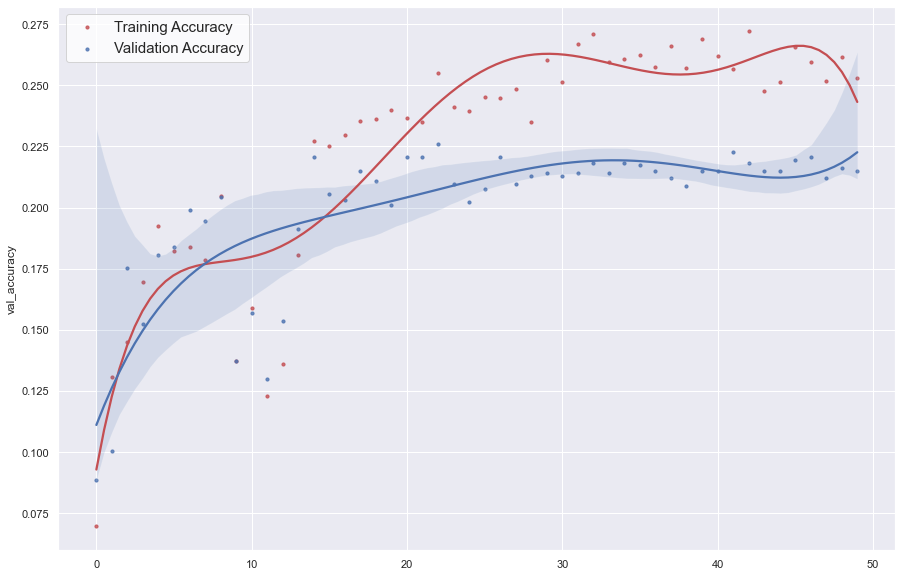

In [32]:
#Stockage des données du modèle dans un Dataframe.
results_bl = pd.DataFrame(history_bl.history)

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x=results_bl.index,y=("accuracy"),data = results_bl,
                 scatter_kws={"s": 10},
                 order=6, ci=None,color='r',label='Training Accuracy')
sns.regplot(x=results_bl.index,y='val_accuracy',data =results_bl,
            scatter_kws={"s": 10}, 
            ax=ax,color='b',order=5,label='Validation Accuracy' )    
ax.legend(facecolor='w',fontsize=15)
plt.show()

# Modèle plus sophistiqué avec 4 couches successives de Conv2D + pooling

In [33]:
from tensorflow.keras import datasets, layers, models
model_bl2 = models.Sequential()
model_bl2.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_bl2.add(layers.MaxPooling2D((2, 2)))
model_bl2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_bl2.add(layers.MaxPooling2D((2, 2)))
model_bl2.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_bl2.add(layers.Flatten())
model_bl2.add(layers.Dense(64, activation='relu'))
model_bl2.add(layers.Dense(n_classes,activation='softmax'))

# Compiler le modèle 
optimizer = SGD(lr=0.01, momentum=0.9)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model_bl2.compile(loss="categorical_crossentropy",
                  optimizer=optimizer, metrics=["accuracy"])

# Set a learning rate annealer
from tensorflow.keras.callbacks import ReduceLROnPlateau
#es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,
                                            factor=0.5, min_lr=0.00001)

batch_size = 64
epochs = 100
history_bl2 = model_bl2.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,validation_data=(X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                             ,callbacks=[learning_rate_reduction])

Epoch 1/100


/Users/florentmargery/miniforge3/envs/fastdash_test/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-06-17 17:29:17.904588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 2.9951 - accuracy: 0.0545

2022-06-17 17:29:30.940555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 15s 394ms/step - loss: 2.9951 - accuracy: 0.0545 - val_loss: 2.9676 - val_accuracy: 0.0757 - lr: 0.0100
Epoch 2/100
33/33 [==============================] - 13s 380ms/step - loss: 2.9126 - accuracy: 0.0879 - val_loss: 2.8203 - val_accuracy: 0.1049 - lr: 0.0100
Epoch 3/100
33/33 [==============================] - 13s 388ms/step - loss: 2.8023 - accuracy: 0.1103 - val_loss: 2.7051 - val_accuracy: 0.1243 - lr: 0.0100
Epoch 4/100
33/33 [==============================] - 13s 379ms/step - loss: 2.6925 - accuracy: 0.1409 - val_loss: 2.6033 - val_accuracy: 0.1405 - lr: 0.0100
Epoch 5/100
33/33 [==============================] - 13s 377ms/step - loss: 2.5910 - accuracy: 0.1633 - val_loss: 2.5617 - val_accuracy: 0.1708 - lr: 0.0100
Epoch 6/100
33/33 [==============================] - 13s 384ms/step - loss: 2.5322 - accuracy: 0.1905 - val_loss: 2.5966 - val_accuracy: 0.1859 - lr: 0.0100
Epoch 7/100
33/33 [==============================] - 12s 370ms/step - 

33/33 [==============================] - 13s 379ms/step - loss: 1.3764 - accuracy: 0.5659 - val_loss: 2.4336 - val_accuracy: 0.2886 - lr: 6.2500e-04
Epoch 49/100
33/33 [==============================] - 13s 377ms/step - loss: 1.3420 - accuracy: 0.5764 - val_loss: 2.4506 - val_accuracy: 0.2941 - lr: 3.1250e-04
Epoch 50/100
33/33 [==============================] - 13s 379ms/step - loss: 1.3500 - accuracy: 0.5735 - val_loss: 2.4597 - val_accuracy: 0.2951 - lr: 3.1250e-04
Epoch 51/100
33/33 [==============================] - 12s 364ms/step - loss: 1.3549 - accuracy: 0.5774 - val_loss: 2.4656 - val_accuracy: 0.2951 - lr: 3.1250e-04
Epoch 52/100
33/33 [==============================] - 12s 354ms/step - loss: 1.3493 - accuracy: 0.5664 - val_loss: 2.4817 - val_accuracy: 0.2962 - lr: 3.1250e-04
Epoch 53/100
33/33 [==============================] - ETA: 0s - loss: 1.3221 - accuracy: 0.5716
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
33/33 [======================

Epoch 94/100
33/33 [==============================] - 12s 371ms/step - loss: 1.3357 - accuracy: 0.5788 - val_loss: 2.4861 - val_accuracy: 0.2962 - lr: 1.0000e-05
Epoch 95/100
33/33 [==============================] - 16s 480ms/step - loss: 1.2851 - accuracy: 0.5909 - val_loss: 2.4862 - val_accuracy: 0.2962 - lr: 1.0000e-05
Epoch 96/100
33/33 [==============================] - 17s 503ms/step - loss: 1.2976 - accuracy: 0.5793 - val_loss: 2.4858 - val_accuracy: 0.2984 - lr: 1.0000e-05
Epoch 97/100
33/33 [==============================] - 17s 501ms/step - loss: 1.2908 - accuracy: 0.5926 - val_loss: 2.4852 - val_accuracy: 0.2973 - lr: 1.0000e-05
Epoch 98/100
33/33 [==============================] - 14s 424ms/step - loss: 1.3194 - accuracy: 0.5740 - val_loss: 2.4865 - val_accuracy: 0.2973 - lr: 1.0000e-05
Epoch 99/100
33/33 [==============================] - 12s 367ms/step - loss: 1.3132 - accuracy: 0.5845 - val_loss: 2.4863 - val_accuracy: 0.2973 - lr: 1.0000e-05
Epoch 100/100
33/33 [=======

## Optimisation des hyperparamètres avec Keras Tuner

In [34]:
def model_builder(hp):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3)))
    model.add(keras.layers.MaxPooling2D(2, 2))

    # Tune the number of filters for the second Conv2D 
    # Choose an optimal value from 64-128
    hp_filters = hp.Choice('num_filters', values=[64, 128], default=64,)
    model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=3, activation='relu'))
    model.add(keras.layers.MaxPooling2D(3,3))

    model.add(keras.layers.Flatten())

    # Tune the Dropout
    # Choose an optimal value between 0.1-0.5
    hp_dropout = hp.Float("dropout_1", min_value=0.1, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(rate=hp_dropout))

    # Tune the number of units in the  Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32,)

    # Tune the activation function for Dense layer
    # Choose an optimal value from relu, tanh, sigmoid
    hp_activation_dense = hp.Choice("dense_activation", values=["relu", "tanh", "sigmoid"], default="relu")
    model.add(keras.layers.Dense(units = hp_units, activation = hp_activation_dense))
    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    model.compile(optimizer = SGD(learning_rate = hp_learning_rate),
                loss = keras.losses.CategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
    return model

In [35]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'bl') 

In [36]:
batch_size = 64
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

tuner.search(datagen.flow(X_train,y_train, batch_size=batch_size), epochs=10,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data = (X_test,y_test),
             verbose = 2, callbacks = [es_callback])

Trial 30 Complete [00h 00m 44s]
val_accuracy: 0.09837838262319565

Best val_accuracy So Far: 0.1275675743818283
Total elapsed time: 00h 11m 07s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


#### On récupère le meilleur modèle identifié.

In [37]:
model_bl2_tuned = tuner.get_best_models()[0]

#### On l'entraine sur nos données d'entrainement (data augmentées).

In [38]:
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
                                           # factor=0.05, min_lr=0.00001

batch_size = 64
epochs = 100 #50,10,200
history_bl2 = model_bl2_tuned.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,validation_data=(X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                             ,callbacks=[learning_rate_reduction])

Epoch 1/100


2022-06-17 18:01:37.232093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 2.8795 - accuracy: 0.1046

2022-06-17 18:01:41.347646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 5s 141ms/step - loss: 2.8795 - accuracy: 0.1046 - val_loss: 2.8582 - val_accuracy: 0.1070 - lr: 0.0100
Epoch 2/100
33/33 [==============================] - 4s 133ms/step - loss: 2.8546 - accuracy: 0.1137 - val_loss: 2.8193 - val_accuracy: 0.1319 - lr: 0.0100
Epoch 3/100
33/33 [==============================] - 4s 129ms/step - loss: 2.8301 - accuracy: 0.1008 - val_loss: 2.7926 - val_accuracy: 0.1081 - lr: 0.0100
Epoch 4/100
33/33 [==============================] - 4s 133ms/step - loss: 2.8052 - accuracy: 0.1242 - val_loss: 2.7620 - val_accuracy: 0.1200 - lr: 0.0100
Epoch 5/100
33/33 [==============================] - 4s 128ms/step - loss: 2.7920 - accuracy: 0.1180 - val_loss: 2.7549 - val_accuracy: 0.1222 - lr: 0.0100
Epoch 6/100
33/33 [==============================] - 4s 127ms/step - loss: 2.7693 - accuracy: 0.1256 - val_loss: 2.7365 - val_accuracy: 0.1308 - lr: 0.0100
Epoch 7/100
33/33 [==============================] - 4s 128ms/step - loss: 2

33/33 [==============================] - 5s 137ms/step - loss: 2.4840 - accuracy: 0.2168 - val_loss: 2.5209 - val_accuracy: 0.1935 - lr: 0.0100
Epoch 54/100
33/33 [==============================] - 5s 138ms/step - loss: 2.4928 - accuracy: 0.2149 - val_loss: 2.5300 - val_accuracy: 0.1935 - lr: 0.0100
Epoch 55/100
33/33 [==============================] - 4s 129ms/step - loss: 2.4739 - accuracy: 0.2197 - val_loss: 2.5071 - val_accuracy: 0.2130 - lr: 0.0100
Epoch 56/100
33/33 [==============================] - 4s 129ms/step - loss: 2.4700 - accuracy: 0.2326 - val_loss: 2.5054 - val_accuracy: 0.2065 - lr: 0.0100
Epoch 57/100
33/33 [==============================] - 4s 126ms/step - loss: 2.4727 - accuracy: 0.2202 - val_loss: 2.5020 - val_accuracy: 0.2011 - lr: 0.0100
Epoch 58/100
33/33 [==============================] - 4s 129ms/step - loss: 2.4525 - accuracy: 0.2264 - val_loss: 2.4989 - val_accuracy: 0.2054 - lr: 0.0100
Epoch 59/100
33/33 [==============================] - 4s 129ms/step - l

## Affichage des résultats Bl2

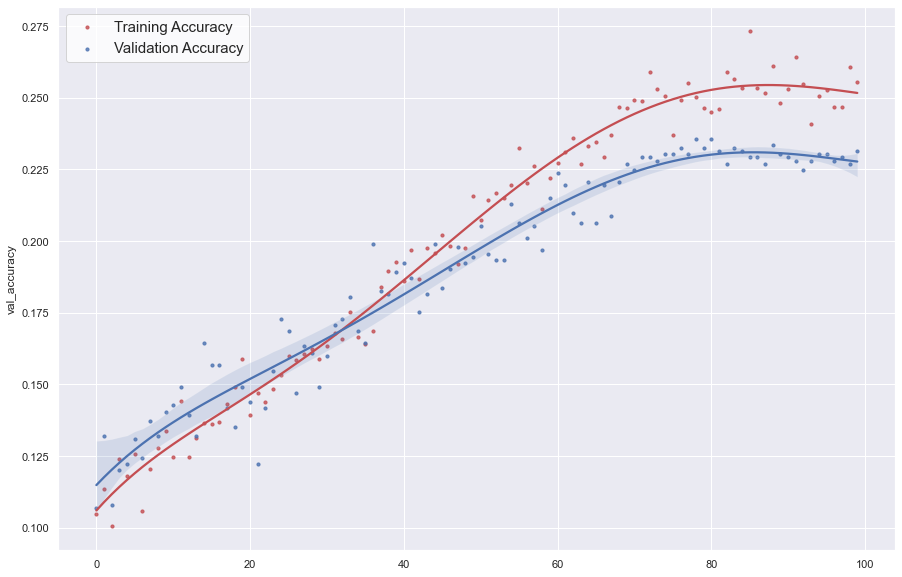

In [39]:
results_bl2 = pd.DataFrame(history_bl2.history)

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x=results_bl2.index,y=("accuracy"),data = results_bl2,
                 scatter_kws={"s": 10},
                 order=6, ci=None,color='r',label='Training Accuracy')
sns.regplot(x=results_bl2.index,y='val_accuracy',data =results_bl2,
            scatter_kws={"s": 10}, 
            ax=ax,color='b',order=5,label='Validation Accuracy' )    
ax.legend(facecolor='w',fontsize=15)
plt.show()

# Création du modèle de Transfer Learning


In [62]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2,ResNet101V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2   
from keras.applications.inception_v3 import InceptionV3

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
#model = VGG16(weights="imagenet", include_top=False, input_shape=(128,128, 3))
#Charger Resnet 
model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128, 3)
)

#weights="resnet50"
#weights="resnetv2" (v4)

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à n classes
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(n_classes, activation='softmax')(class1)

# Définir le nouveau modèle
model_tl = Model(inputs=model.input, outputs=output)


In [63]:
# On n'entraine que les layers du dessus déstinés à la classification de nos images.
for layer in model_tl.layers[:(len(model_tl.layers)-3)]:
    layer.trainable = False
    
# Compiler le modèle 
#optimizer = SGD(lr=0.001, momentum=0.9)
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model_tl.compile(loss="categorical_crossentropy",
                  optimizer=optimizer, metrics=["accuracy"])

/Users/florentmargery/miniforge3/envs/fastdash_test/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [64]:
model_tl.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 63, 63, 32)  96          ['conv2d_203[0][0]']             
 Normalization)                                                                                   
                                                                                            

 batch_normalization_213 (Batch  (None, 13, 13, 96)  288         ['conv2d_213[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_214 (Batch  (None, 13, 13, 64)  192         ['conv2d_214[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_208 (Activation)    (None, 13, 13, 96)   0           ['batch_normalization_208[0][0]']
                                                                                                  
 activation_210 (Activation)    (None, 13, 13, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 activatio

 batch_normalization_222 (Batch  (None, 13, 13, 32)  96          ['conv2d_222[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_225 (Batch  (None, 13, 13, 48)  144         ['conv2d_225[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_222 (Activation)    (None, 13, 13, 32)   0           ['batch_normalization_222[0][0]']
                                                                                                  
 activation_225 (Activation)    (None, 13, 13, 48)   0           ['batch_normalization_225[0][0]']
                                                                                                  
 conv2d_22

                                                                                                  
 block35_3_mixed (Concatenate)  (None, 13, 13, 128)  0           ['activation_227[0][0]',         
                                                                  'activation_229[0][0]',         
                                                                  'activation_232[0][0]']         
                                                                                                  
 block35_3_conv (Conv2D)        (None, 13, 13, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 13, 13, 320)  0           ['block35_2_ac[0][0]',           
                                                                  'block35_3_conv[0][0]']         
                                                                                                  
 block35_3

                                                                                                  
 activation_243 (Activation)    (None, 13, 13, 48)   0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_239 (Conv2D)            (None, 13, 13, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_241 (Conv2D)            (None, 13, 13, 32)   9216        ['activation_240[0][0]']         
                                                                                                  
 conv2d_244 (Conv2D)            (None, 13, 13, 64)   27648       ['activation_243[0][0]']         
                                                                                                  
 batch_normalization_239 (Batch  (None, 13, 13, 32)  96          ['conv2d_239[0][0]']             
 Normaliza

 block35_6 (Lambda)             (None, 13, 13, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 13, 13, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_254 (Conv2D)            (None, 13, 13, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_254 (Batch  (None, 13, 13, 32)  96          ['conv2d_254[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_262 (Conv2D)            (None, 13, 13, 64)   27648       ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_257 (Batch  (None, 13, 13, 32)  96          ['conv2d_257[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_259 (Batch  (None, 13, 13, 32)  96          ['conv2d_259[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_262 (Batch  (None, 13, 13, 64)  192         ['conv2d_262[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_272 (Batch  (None, 13, 13, 32)  96          ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_272 (Activation)    (None, 13, 13, 32)   0           ['batch_normalization_272[0][0]']
                                                                                                  
 conv2d_270 (Conv2D)            (None, 13, 13, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_273 (Conv2D)            (None, 13, 13, 48)   13824       ['activation_272[0][0]']         
                                                                                                  
 batch_normalization_270 (Batch  (None, 13, 13, 32)  96          ['conv2d_270[0][0]']             
 Normaliza

                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_280 (Conv2D)            (None, 6, 6, 128)    139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_280 (Batch  (None, 6, 6, 128)   384         ['conv2d_280[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_280 (Activation)    (None, 6, 6, 128)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 conv2d_281 (Conv2D)            (None, 6, 6, 160)    143360      ['activation_280[0][0]']         
          

 activation_288 (Activation)    (None, 6, 6, 128)    0           ['batch_normalization_288[0][0]']
                                                                                                  
 conv2d_289 (Conv2D)            (None, 6, 6, 160)    143360      ['activation_288[0][0]']         
                                                                                                  
 batch_normalization_289 (Batch  (None, 6, 6, 160)   480         ['conv2d_289[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_289 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_289[0][0]']
                                                                                                  
 conv2d_287 (Conv2D)            (None, 6, 6, 192)    208896      ['block17_2_ac[0][0]']           
          

 activation_297 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_297[0][0]']
                                                                                                  
 conv2d_295 (Conv2D)            (None, 6, 6, 192)    208896      ['block17_4_ac[0][0]']           
                                                                                                  
 conv2d_298 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_297[0][0]']         
                                                                                                  
 batch_normalization_295 (Batch  (None, 6, 6, 192)   576         ['conv2d_295[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_298 (Batch  (None, 6, 6, 192)   576         ['conv2d_298[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_306 (Batch  (None, 6, 6, 192)   576         ['conv2d_306[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_303 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_303[0][0]']
                                                                                                  
 activation_306 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_306[0][0]']
                                                                                                  
 block17_7_mixed (Concatenate)  (None, 6, 6, 384)    0           ['activation_303[0][0]',         
          

 activation_314 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_314[0][0]']
                                                                                                  
 block17_9_mixed (Concatenate)  (None, 6, 6, 384)    0           ['activation_311[0][0]',         
                                                                  'activation_314[0][0]']         
                                                                                                  
 block17_9_conv (Conv2D)        (None, 6, 6, 1088)   418880      ['block17_9_mixed[0][0]']        
                                                                                                  
 block17_9 (Lambda)             (None, 6, 6, 1088)   0           ['block17_8_ac[0][0]',           
                                                                  'block17_9_conv[0][0]']         
                                                                                                  
 block17_9

 block17_11 (Lambda)            (None, 6, 6, 1088)   0           ['block17_10_ac[0][0]',          
                                                                  'block17_11_conv[0][0]']        
                                                                                                  
 block17_11_ac (Activation)     (None, 6, 6, 1088)   0           ['block17_11[0][0]']             
                                                                                                  
 conv2d_324 (Conv2D)            (None, 6, 6, 128)    139264      ['block17_11_ac[0][0]']          
                                                                                                  
 batch_normalization_324 (Batch  (None, 6, 6, 128)   384         ['conv2d_324[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_332 (Batch  (None, 6, 6, 128)   384         ['conv2d_332[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_332 (Activation)    (None, 6, 6, 128)    0           ['batch_normalization_332[0][0]']
                                                                                                  
 conv2d_333 (Conv2D)            (None, 6, 6, 160)    143360      ['activation_332[0][0]']         
                                                                                                  
 batch_normalization_333 (Batch  (None, 6, 6, 160)   480         ['conv2d_333[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_341 (Batch  (None, 6, 6, 160)   480         ['conv2d_341[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_341 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_341[0][0]']
                                                                                                  
 conv2d_339 (Conv2D)            (None, 6, 6, 192)    208896      ['block17_15_ac[0][0]']          
                                                                                                  
 conv2d_342 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_341[0][0]']         
                                                                                                  
 batch_normalization_339 (Batch  (None, 6, 6, 192)   576         ['conv2d_339[0][0]']             
 Normaliza

 conv2d_350 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_349[0][0]']         
                                                                                                  
 batch_normalization_347 (Batch  (None, 6, 6, 192)   576         ['conv2d_347[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_350 (Batch  (None, 6, 6, 192)   576         ['conv2d_350[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_347 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_347[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_355 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_355[0][0]']
                                                                                                  
 activation_358 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_358[0][0]']
                                                                                                  
 block17_20_mixed (Concatenate)  (None, 6, 6, 384)   0           ['activation_355[0][0]',         
                                                                  'activation_358[0][0]']         
                                                                                                  
 block17_20_conv (Conv2D)       (None, 6, 6, 1088)   418880      ['block17_20_mixed[0][0]']       
                                                                                                  
 block17_2

 activation_368 (Activation)    (None, 2, 2, 224)    0           ['batch_normalization_368[0][0]']
                                                                                                  
 conv2d_366 (Conv2D)            (None, 2, 2, 192)    399360      ['mixed_7a[0][0]']               
                                                                                                  
 conv2d_369 (Conv2D)            (None, 2, 2, 256)    172032      ['activation_368[0][0]']         
                                                                                                  
 batch_normalization_366 (Batch  (None, 2, 2, 192)   576         ['conv2d_366[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_369 (Batch  (None, 2, 2, 256)   768         ['conv2d_369[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_377 (Batch  (None, 2, 2, 256)   768         ['conv2d_377[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_374 (Activation)    (None, 2, 2, 192)    0           ['batch_normalization_374[0][0]']
                                                                                                  
 activation_377 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_377[0][0]']
                                                                                                  
 block8_3_mixed (Concatenate)   (None, 2, 2, 448)    0           ['activation_374[0][0]',         
          

 activation_385 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_385[0][0]']
                                                                                                  
 block8_5_mixed (Concatenate)   (None, 2, 2, 448)    0           ['activation_382[0][0]',         
                                                                  'activation_385[0][0]']         
                                                                                                  
 block8_5_conv (Conv2D)         (None, 2, 2, 2080)   933920      ['block8_5_mixed[0][0]']         
                                                                                                  
 block8_5 (Lambda)              (None, 2, 2, 2080)   0           ['block8_4_ac[0][0]',            
                                                                  'block8_5_conv[0][0]']          
                                                                                                  
 block8_5_

 block8_7 (Lambda)              (None, 2, 2, 2080)   0           ['block8_6_ac[0][0]',            
                                                                  'block8_7_conv[0][0]']          
                                                                                                  
 block8_7_ac (Activation)       (None, 2, 2, 2080)   0           ['block8_7[0][0]']               
                                                                                                  
 conv2d_395 (Conv2D)            (None, 2, 2, 192)    399360      ['block8_7_ac[0][0]']            
                                                                                                  
 batch_normalization_395 (Batch  (None, 2, 2, 192)   576         ['conv2d_395[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_403 (Batch  (None, 2, 2, 192)   576         ['conv2d_403[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_403 (Activation)    (None, 2, 2, 192)    0           ['batch_normalization_403[0][0]']
                                                                                                  
 conv2d_404 (Conv2D)            (None, 2, 2, 224)    129024      ['activation_403[0][0]']         
                                                                                                  
 batch_normalization_404 (Batch  (None, 2, 2, 224)   672         ['conv2d_404[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [65]:
# Set a learning rate annealer

#es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1,
                                            factor=0.5, min_lr=0.00001)

batch_size = 128
epochs = 50
history_tl = model_tl.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,validation_data=(X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

/var/folders/j4/7y0hj60n09q_n50qxfl1rr4w0000gn/T/ipykernel_24449/1347847635.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_tl = model_tl.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/50


2022-06-17 19:17:20.272367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-17 19:17:36.021150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 - 30s - loss: 50.6080 - accuracy: 0.3182 - val_loss: 7.3630 - val_accuracy: 0.6097 - lr: 0.0010 - 30s/epoch - 2s/step
Epoch 2/50
16/16 - 8s - loss: 4.4268 - accuracy: 0.6645 - val_loss: 3.5671 - val_accuracy: 0.6995 - lr: 0.0010 - 8s/epoch - 527ms/step
Epoch 3/50
16/16 - 8s - loss: 5.6569 - accuracy: 0.6143 - val_loss: 4.9604 - val_accuracy: 0.6800 - lr: 0.0010 - 8s/epoch - 475ms/step
Epoch 4/50
16/16 - 8s - loss: 3.0451 - accuracy: 0.6936 - val_loss: 1.7145 - val_accuracy: 0.7741 - lr: 0.0010 - 8s/epoch - 523ms/step
Epoch 5/50
16/16 - 8s - loss: 2.7582 - accuracy: 0.6823 - val_loss: 2.6568 - val_accuracy: 0.6832 - lr: 0.0010 - 8s/epoch - 498ms/step
Epoch 6/50
16/16 - 8s - loss: 2.1092 - accuracy: 0.7177 - val_loss: 2.2173 - val_accuracy: 0.7135 - lr: 0.0010 - 8s/epoch - 494ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 - 8s - loss: 2.2362 - accuracy: 0.6808 - val_loss: 1.7645 - val_accuracy: 0.7297 - lr: 0.0010 - 8s/epoch - 

# Optimisation du modèle de transfert learning avec Keras Tuner 

## Sauvegarde du modèle

In [67]:
directory = "/Users/florentmargery/Documents/Open Classroom/Projet 6/" 
# On se place dans le dossier fils
os.chdir(directory)
model_tl.save('Model_trained_2')

INFO:tensorflow:Assets written to: Model_trained_2/assets


INFO:tensorflow:Assets written to: Model_trained_2/assets


In [68]:
model_loaded = keras.models.load_model('Model_trained_2')

In [69]:
model_loaded.evaluate(X_test,y_test)

2022-06-17 19:24:51.228462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 16s 394ms/step - loss: 0.8302 - accuracy: 0.7935


[0.830208420753479, 0.7935135364532471]

### Affichage des résultats

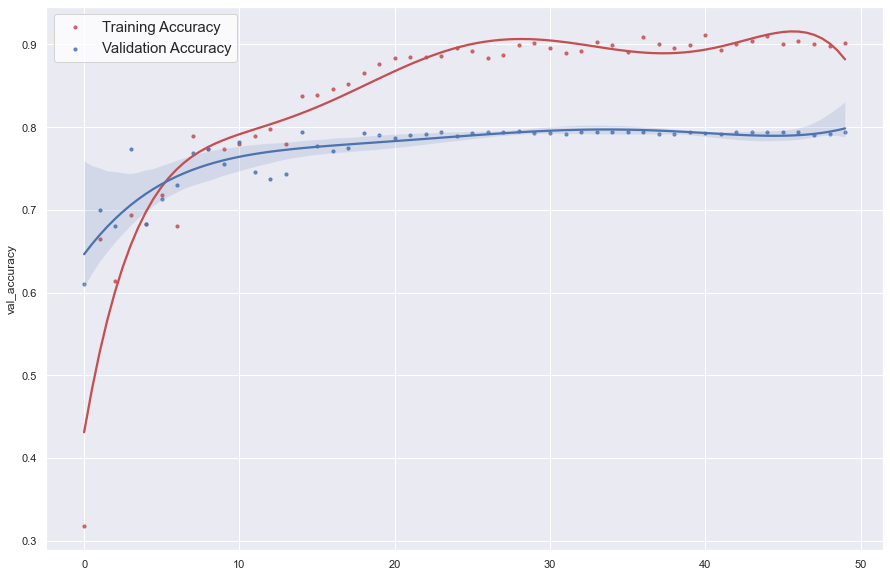

In [66]:
#On récupère les infos de notre modèle sous forme de dataframe.
results_tl = pd.DataFrame(history_tl.history)

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x=results_tl.index,y=("accuracy"),data = results_tl,
                 scatter_kws={"s": 10},
                 order=6, ci=None,color='r',label='Training Accuracy')
sns.regplot(x=results_tl.index,y='val_accuracy',data =results_tl,
            scatter_kws={"s": 10}, 
            ax=ax,color='b',order=5,label='Validation Accuracy' )    
ax.legend(facecolor='w',fontsize=15)
plt.show()

# Analyse générale des résultats 

In [70]:
results_general = pd.DataFrame(columns={'Val_accuracy','Model'})

In [71]:
history_to_check = [history_bl,history_bl2,history_tl]

In [72]:
for history in history_to_check : 
    
    # Les modèles ont été compilés avec leur propres paramètres en amont.
    # Ici, on ne fait que le fit sur les données d'entrainement. 
    
    to_concatenate = [history.history['val_accuracy'][-1:],str(history)]
    results_general = results_general.append(pd.Series(to_concatenate, index = ['Val_accuracy','Model']), 
           ignore_index=True)

/var/folders/j4/7y0hj60n09q_n50qxfl1rr4w0000gn/T/ipykernel_24449/1852333027.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_general = results_general.append(pd.Series(to_concatenate, index = ['Val_accuracy','Model']),
/var/folders/j4/7y0hj60n09q_n50qxfl1rr4w0000gn/T/ipykernel_24449/1852333027.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_general = results_general.append(pd.Series(to_concatenate, index = ['Val_accuracy','Model']),
/var/folders/j4/7y0hj60n09q_n50qxfl1rr4w0000gn/T/ipykernel_24449/1852333027.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_general = results_general.append(pd.Series(to_concatenate, index = ['Val_accuracy','Model']),


In [73]:
results_general.Val_accuracy = [results_bl.val_accuracy[-1:].values[0],
               results_bl2.val_accuracy[-1:].values[0],
               results_tl.val_accuracy[-1:].values[0]]

results_general.Model = ['Baseline','Baseline 2', 'Transfer Learning']

In [74]:
results_general

,Val_accuracy,Model
0,0.215135,Baseline
1,0.231351,Baseline 2
2,0.793514,Transfer Learning


<AxesSubplot:xlabel='Model', ylabel='Val_accuracy'>

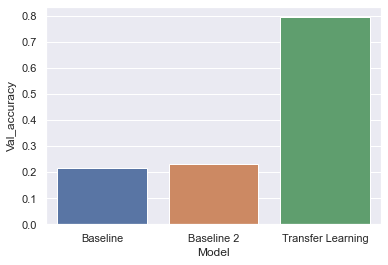

In [75]:
sns.barplot(x= 'Model', y='Val_accuracy',data= results_general)